In [1]:
import src.arctic as arctic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data
- provided by the Institute of Atmospheric Physics Kühlungsborn (IAP)
- ERA5: daily means at pressure levels and analysis
    - Intercomparison with Hannachi et al. (2011)
    - SWE1.tar: contains major warming diagnostics
    - SWE1.tar: elliptic diagnostics of Z10
    - SWX1.tar: extended diagnostics (reachable via VPN)
    - SWC1.tar: classfiication synthesis (reachable via VPN)

#### File structure
netCDF files are 3-dimensional data, investigated with ncdump. The .tar-files contain all output from Christoph Zülickes diagnosis, in particular:
- SWM: ASCII values in 2 files, 
    1. *cen.csv with the major warming events as identified with their central day when the wind turned from westerly to easterly along with some characteristics and
    2. *msw.csv with daily lists with wind and a marker mw for major warming
- SWE: 1 csv file
    - *d.csv: daily list of indices, including the aspect ratio of the mother vortex (ar), centrail latitude (latcent) and area (area)

In [2]:
# read data
era5_d = arctic.read_data("data/SWXClust/ERA5/e5e1_d.csv")
era5_cen = arctic.read_data("data/SWXClust/ERA5/e5m1t-cen.csv")
era5_msw = arctic.read_data("data/SWXClust/ERA5/e5m1t-msw.csv")

# remove white space from column names
arctic.no_white_space(era5_d)
arctic.no_white_space(era5_cen)
arctic.no_white_space(era5_msw)

# change string to datetime for better comparison
arctic.to_date(era5_d, 'string')
arctic.to_date(era5_cen, 'string')
arctic.to_date(era5_msw, 'string')

# merge era5 data to one big dataframe
era5_all = era5_d.merge(era5_msw, on ='string', how='left', suffixes=[None, '_msw']).merge(era5_cen, on='string', how='left', suffixes = ['_d', '_cen'])

# handling string encodings
era5_all['form'] = era5_all['form'].replace({' D' : 0, ' S': 1})
# handling NaN values and string encodings
era5_all['MW'] = pd.to_numeric(era5_all.MW.replace({'   ': 0, ' MW' : 1}))
era5_all[era5_cen.columns[-4:]] = era5_all[era5_cen.columns[-4:]].fillna(0) 
era5_all.columns

era5_all.head()

,D_d,counter_d,time_d,string,year,month,day,hour,level,edge,...,u,MW,D_cen,num,counter_cen,time_cen,pers,Umax,Imax,Iacc
0,D,1,2438031.25,1963-01-01 18:00:00,1963,1,1,18,10.0,29.2,...,59.7,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,D,2,2438032.25,1963-02-01 18:00:00,1963,1,2,18,10.0,29.2,...,59.6,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,D,3,2438033.25,1963-03-01 18:00:00,1963,1,3,18,10.0,29.2,...,58.8,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,D,4,2438034.25,1963-04-01 18:00:00,1963,1,4,18,10.0,29.2,...,58.5,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,D,5,2438035.25,1963-05-01 18:00:00,1963,1,5,18,10.0,29.2,...,58.3,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


## Reconstruction of same conditions as Hannachi et al.
- time: winterperiod (december to march) from 1958 to 2002, activity peaks in dec - jan, oscilliation period around 120-130d
    - **Note**: only data after 1963 available 
- 7 stratospheeric variables:

| temp. (lat1) | temp (lat2) |temp. (lat3) | avg. zon. wind (lat1) | avg. zon. wind (lat2) | wave-1                    | wave-2                    |
|--------------|-------------|------------------|-----------------------|-----------------------|---------------------------|---------------------------|
| Zonally averaged | Zonally averaged | Zonally averaged | Zonally averaged <br/ | Zonally averaged      | Normalised by zonal winds | Normalised by zonal winds |
| 60-70°N      | 70-80°N     | 80-90°N          | 60-70°N               | 70-80°N               | 60°N                      | 60°N                      |

- 7 pressure levels between 100 to 1hPa
- geometrical features: latitude centroid (lat), area (area), aspect ratio (AR) - kurtosis omitted due to skewness

#### Approaches
1. Hierarchical Clustering
    - Used distance: Euclidean distance
    - Distance between Cluster: Complete Linkage to avoid chain and spheroidal tendencies of single and average linkage
    - Gap statistic to find number of clusters with Poisson point process (standard)
    - SSA to deal with seasonality and its variation

|               | between points in Cluster | Different                                  |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |

In [3]:
# time constraints
era5_hannachi = era5_all[(era5_all['string'] < '01-01-2003') & 
                     (era5_all['month']).isin([12,1,2,3])]

era5_hannachi = era5_hannachi[['year', 'month', 'day', 'area', 'ar', 'latcent', 'kurtosis']]
# check for completeness
era5_hannachi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4850 entries, 0 to 14609
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      4850 non-null   int64  
 1   month     4850 non-null   int64  
 2   day       4850 non-null   int64  
 3   area      4850 non-null   float64
 4   ar        4850 non-null   float64
 5   latcent   4850 non-null   float64
 6   kurtosis  4850 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 303.1 KB


In [4]:
from sklearn.cluster import AgglomerativeClustering

In [14]:
gap_values_ar_latcent = arctic.gap_statistic(era5_hannachi[['ar', 'latcent']], k_max=10, n_replicates=15)
gap_values_all = arctic.gap_statistic(era5_hannachi, k_max=10, n_replicates=15)
gap_values_ar_latcent_area = arctic.gap_statistic(era5_hannachi[['ar', 'latcent', 'area']], k_max=10, n_replicates=15)

elbow_values_ar_latcent = arctic.elbow_method(era5_hannachi[['ar', 'latcent']], k_max=10)
elbow_values_all = arctic.elbow_method(era5_hannachi, k_max=10)
elbow_values_ar_latcent_area = arctic.elbow_method(era5_hannachi[['ar', 'latcent', 'area']], k_max=10)

silhouette_values_ar_latcent = arctic.silhouette_method(era5_hannachi[['ar', 'latcent']], k_max=10)
silhouette_values_all = arctic.silhouette_method(era5_hannachi, k_max=10)
silhouette_values_ar_latcent_area = arctic.silhouette_method(era5_hannachi[['ar', 'latcent', 'area']], k_max=10)

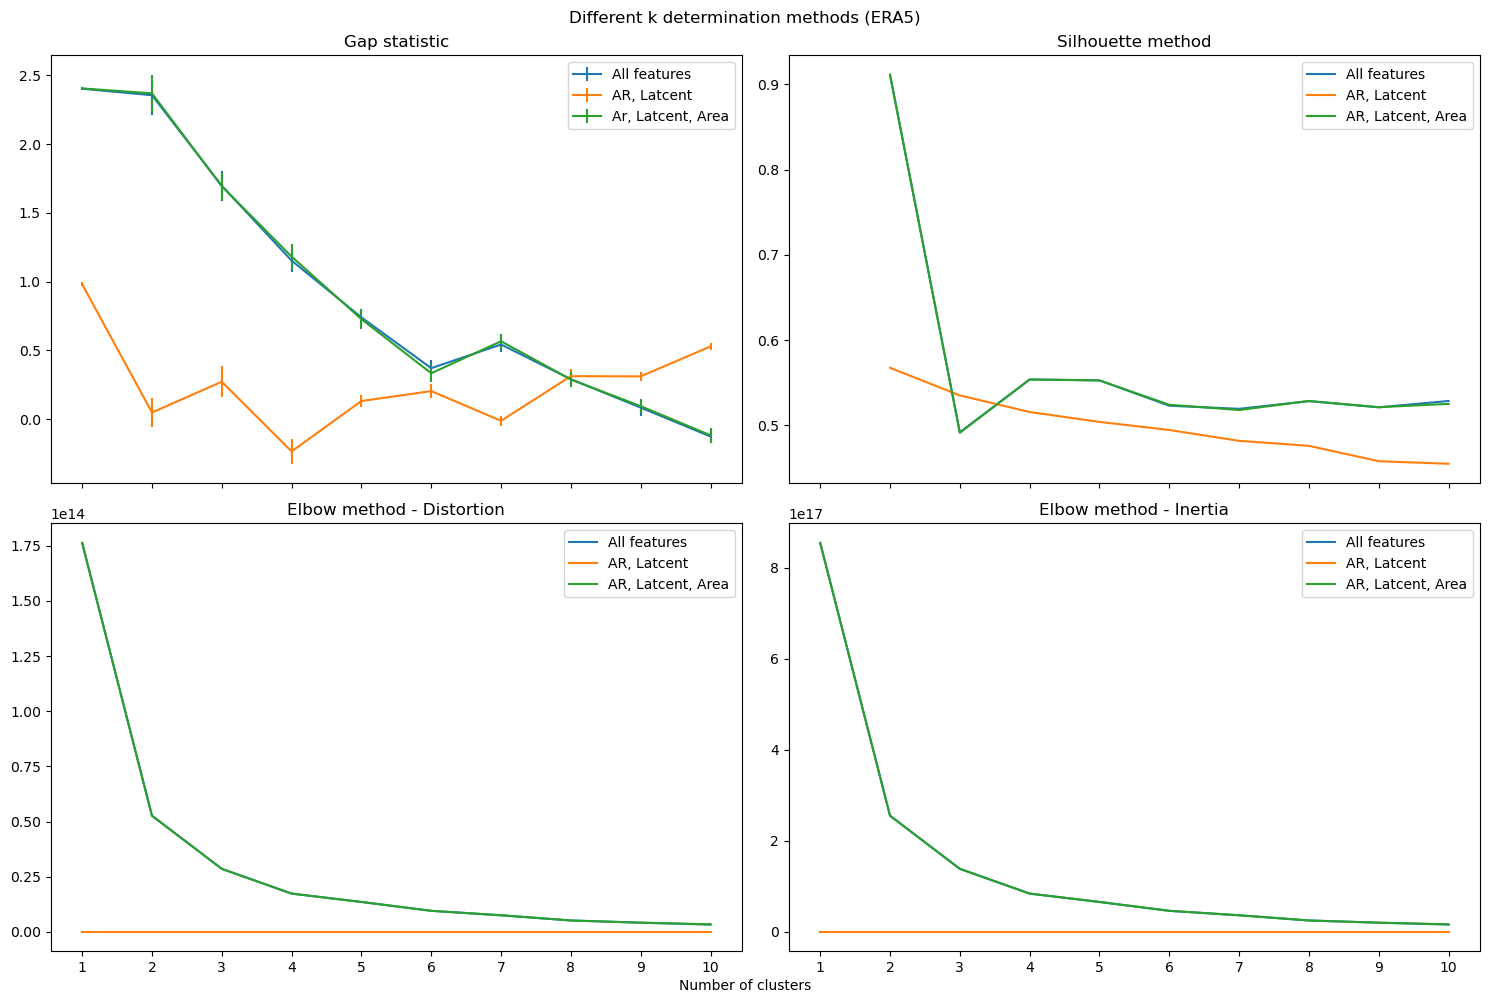

In [25]:
fig, ax = plt.subplots(2,2, figsize=(15, 10), sharex=True)
ax[0][0].errorbar(np.arange(1,11), gap_values_all[:, 0], yerr=gap_values_all[:, 1], label='All features')
ax[0][0].errorbar(np.arange(1,11), gap_values_ar_latcent[:, 0], yerr=gap_values_ar_latcent[:, 1], label='AR, Latcent')
ax[0][0].errorbar(np.arange(1,11), gap_values_ar_latcent_area[:, 0], yerr=gap_values_ar_latcent_area[:, 1], label='Ar, Latcent, Area')
ax[0][0].set_title('Gap statistic')
ax[0][0].legend()

ax[1][0].plot(np.arange(1,11), elbow_values_all[:][0], label='All features')
ax[1][0].plot(np.arange(1,11), elbow_values_ar_latcent[:][0], label='AR, Latcent')
ax[1][0].plot(np.arange(1,11), elbow_values_ar_latcent_area[:][0], label='AR, Latcent, Area')
ax[1][0].set_title('Elbow method - Distortion')
# ax[1][0].set_yscale('log')
ax[1][0].legend()

ax[1][1].plot(np.arange(1,11), elbow_values_all[:][1], label='All features')
ax[1][1].plot(np.arange(1,11), elbow_values_ar_latcent[:][1], label='AR, Latcent')
ax[1][1].plot(np.arange(1,11), elbow_values_ar_latcent_area[:][1], label='AR, Latcent, Area')
ax[1][1].set_title('Elbow method - Inertia')
# ax[1][1].set_yscale('log')
ax[1][1].legend()

ax[0][1].plot(np.arange(2,11), silhouette_values_all, label='All features')
ax[0][1].plot(np.arange(2,11), silhouette_values_ar_latcent, label='AR, Latcent')
ax[0][1].plot(np.arange(2,11), silhouette_values_ar_latcent_area, label='AR, Latcent, Area')
ax[0][1].set_title('Silhouette method')
ax[0][1].legend()

plt.suptitle('Different k determination methods (ERA5)')
plt.xticks(np.arange(1, 11))
fig.text(0.5, 0, 'Number of clusters', ha='center')
plt.tight_layout()
plt.savefig('./output/Kopt_era5.png')
plt.show()


In [ ]:
X = era5_hannachi
hc = AgglomerativeClustering(n_clusters=3,
                             linkage='complete',
                             compute_distances=True).fit(X)
hc_label = hc.labels_

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42).fit(X)
kmeans_label = kmeans.labels_

In [ ]:
era5_hannachi['hc'] = hc_label
era5_hannachi['kmeans'] = kmeans_label
# compare label with mw, c/d, s/d
corr = era5_hannachi.corr()
corr[['kmeans', 'hc']].style.background_gradient(vmin=-1, vmax=1, cmap='RdBu')

In [ ]:
print(era5_hannachi.shape)
print("Label distribution by hierarchical clustering: ")
print('0 : ', era5_hannachi[era5_hannachi.hc == 0].shape) # 74
print('1 : ', era5_hannachi[era5_hannachi.hc == 1].shape) # 403
print('2 : ', era5_hannachi[era5_hannachi.hc == 2].shape) # 4624

print("Label distribution by kmeans clustering: ")
print('0 : ', era5_hannachi[era5_hannachi.kmeans == 0].shape) # 74
print('1 : ', era5_hannachi[era5_hannachi.kmeans == 1].shape) # 403
print('2 : ', era5_hannachi[era5_hannachi.kmeans == 2].shape) # 4624
print('3: ', era5_hannachi[era5_hannachi.kmeans==3].shape)

### Results from Hannachi et al.

| AR and Latc of vortex/AR, Lat, filtered vortex area | D  | U  | S  | Total |
|-----------------------------------------------------|----|----|----|-------|
| D                                                   | 7  |  3 | 0  | 10    |
| U                                                   | 4  | 80 | 2  | 86    |
| S                                                   | 1  | 0  | 3  | 4     |
| Total                                               | 12 | 83 | 5  | 100   |

### Results with Agglomorative Clustering:

| Label | Absolut | Perc (%) | Comment                                                                                                      |
|-------|---------|----------|--------------------------------------------------------------------------------------------------------------|
| 0     | 74      | 1,5      | Probably S<br/>Remains the same when removing other features<br/>74 when only area, latcent and ar were used |
| 1     | 403     | 8        | Probably D  <br/> Varies wildly when features removed                                                        |
| 2     | 4624    | 90,6     | Probably U  <br/>Varies wildly when features removed                                                         |
| Total | 5101    | 100      | --                                                                                                           |

Influence of different linkages:
- complete: used by Hannachi, dendogram does not indicate 3 clusters
- ward: appears similar to kmeans in distribution
- single: makes very weird Cluster with distribution 70, 4, 5027; indicates 3 Clusters
- average: makes also weird Cluster with distribution 70, 23, 5008; indicates 3 Clusters

### Results with kmeans Clustering:

| Label | Absolut | Perc (%)   | Comment                                                                                                      |
|-------|---------|------------|--------------------------------------------------------------------------------------------------------------|
| 0     | 2000    | 39,25      | Maybe D  <br/> Varies wildly, depending on features and random seed                                          |
| 1     | 79      | 1,5        | Probably S<br/>Remains the same when removing other features<br/>74 when only area, latcent and ar were used |
| 2     | 3022    | 59,25      | Maybe U  <br/>Varies wildly, just as D                                                                       |
| Total | 5101    | 100        | --                                                                                                           

#### Evaluation
S and U are underrepresented. Different measures?
Go for troubleshooting:
- Outliers? (~75?)
- Can I - based on my available data - differentiate between S, U, D?
- Data differences (s. previous part)
- Description of found cluster matching with Hannachi/general what are they?

Hierarchical cluster depends severly on **area**

In [ ]:
# Dendrogram
arctic.plot.plot_dendrogram(hc, truncate_mode='level', p=3, savefig='output/hc.png')

# Biplot
pc=5
# note "label" excluded from pca due to duplication of data.
era5_hannachi['label'] = era5_hannachi['hc']
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_hc_3D.png')
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', savefig='output/pca_era5_hc_2D.png')
# Radar chart
def own_agg(x):
    return x.quantile(0.75)
arctic.plot.plot_radar(era5_hannachi, label='kmeans')
arctic.plot.plot_radar(era5_hannachi, agg_func=own_agg)

# Violinplot
arctic.plot_violin(era5_hannachi)

In [ ]:
# check time integrity of clustering
print("Distribution cluster: ", era5_hannachi.hc.value_counts())
print("Distribution form: ", era5_hannachi.form.value_counts())
era5_hannachi.groupby(['year', 'hc']).count()['label']

In [ ]:
era5_hannachi.groupby(['form', 'hc']).count()['label']